# Heston Model Calibration and Simulation
---


# Reference
QuantPy. (2022). Heston Model Calibration to option prices. Retrieved from:

https://github.com/TheQuantPy/youtube-tutorials/blob/0f91e06f86ba2da184b078260e62dc6501eb1792/2022/001%20Jan-Mar/2022-03-25%20Heston%20Model%20Calibration%20in%20the%20_Real_%20World%20with%20Python%20-%20S_P500%20Index%20Options.ipynb

## Model Specification

### Heston's Stochastic Volatility Model under real world probability measure

$\large dS_t = \mu S_t dt + \sqrt{v_t} S_t dW^\mathbb{P}_{1,t}$

$\large dv_t = \kappa (\theta - v_t)dt + \sigma \sqrt{v_t} dW^\mathbb{P}_{2,t}$

$\large \rho dt = dW^\mathbb{P}_{2,t} dW^\mathbb{P}_{2,t} $

### Using Girsanov's Thereom to $\mathbb{P} \to \mathbb{Q}$
$\large dW^\mathbb{Q}_{S,t} = dW^\mathbb{P}_{S,t} + \alpha_S dt, \alpha_S  = \frac{\mu_\mathbb{P}-r}{\sqrt{v_t}}$

$\large dW^\mathbb{Q}_{v,t} = dW^\mathbb{P}_{v,t} + \alpha_v dt, \alpha_v  = \frac{\lambda}{\sigma^\mathbb{P}} \sqrt{v_t}$


### Heston's Stochastic Volatility Model under risk-neutral measure

$\large dS_t = r S_t dt + \sqrt{v_t} S_t dW^\mathbb{Q}_{1,t}$

$\large dv_t = \kappa^\mathbb{Q} (\theta^\mathbb{Q} - v_t)dt + \sigma \sqrt{v_t} dW^\mathbb{Q}_{2,t}$

$\large \rho^\mathbb{Q} dt = dW^\mathbb{Q}_{2,t} dW^\mathbb{Q}_{2,t} $

Where: $\large \lambda$ is the variance risk premium

$\large \rho^\mathbb{Q} = \rho, \kappa^\mathbb{Q} = \kappa+\lambda,  \theta^\mathbb{Q} = \kappa \theta/(\kappa+\lambda)$

Notation:
- $S_t$ Equity spot price, financial index
- $v_t$ Variance.
- $C$ European call option price.
- $K$ Strike price.
- $W_{1,2}$ Standard Brownian movements.
- $r$ Interest rate.
- $\kappa$ Mean reversion rate.
- $\theta$ Long run variance.
- $v_0$ Initial variance.
- $\sigma$ Volatility of variance.
- $\rho$ Correlation parameter.
- $t$ Current date.
- $T$ Maturity date.

---

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.stats import norm
from datetime import datetime as dt

import yfinance as yf


In [2]:
os.chdir('C:/Users/tic19/OneDrive - The Chinese University of Hong Kong/My Documents/Courses/Current/RMSC4007/project')

In [3]:
valuation_date = dt(2022,11,10)
S0_close_KO = 60.88
S0_close_MCD = 275.88
S0_close_SBUX = 96.26

S0_adjcls_KO = 59.07
S0_adjcls_MCD = 269.87
S0_adjcls_SBUX = 94.28

div_KO = 0.03
div_MCD = 0.0216
div_SBUX = 0.0209

SIM_STEPS = 252 # Number of steps used in discretisation
T = 1 # Tenor of embedding option
RF_1Y = 0.04578


## Model Calibration

### 1. Implement the characteristic function of $\large P_1$ and $\large P_2$ in the BS-like semi-analytical solution

$\large \varphi(X_0, K, v_0,\tau; \phi) = e^{r \phi i \tau} S^{i \phi}[\frac{1-ge^{d\tau}}{1-g}]^{\frac{-2a}{\sigma^2}} exp[\frac{a \tau}{\sigma^2} (b_2 -\rho\sigma \phi i + d) + \frac{v_0}{\sigma^2}(b_2 -\rho\sigma \phi i + d)[\frac{1-e^{d\tau}}{1-ge^{d\tau}}]]$

- $\large d = \sqrt{(\rho\sigma \phi i - b)^2 + \sigma^2 (\phi i + \phi^2)}$
- $\large g = \frac{b -\rho\sigma \phi i + d}{b -\rho\sigma \phi i - d}$
- $\large a = \kappa \theta$
- $\large b = \kappa + \lambda$

In [4]:
def heston_charfunc(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):

    # constants
    a = kappa*theta
    b = kappa+lambd

    # common terms w.r.t phi
    rspi = rho*sigma*phi*1j

    # define d parameter given phi and b
    d = np.sqrt( (rho*sigma*phi*1j - b)**2 + (phi*1j+phi**2)*sigma**2 )

    # define g parameter given phi, b and d
    g = (b-rspi+d)/(b-rspi-d)

    # calculate characteristic function by components
    exp1 = np.exp(r*phi*1j*tau)
    term2 = S0**(phi*1j) * ( (1-g*np.exp(d*tau))/(1-g) )**(-2*a/sigma**2)
    exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)

    return exp1*term2*exp2

### 2. Implement the intergrand

$\large \int^∞_0 \Re [ e^{-r\tau} \frac{\varphi(\phi-i)}{i\phi K^{i\phi}} - Ke^{-r\tau}\frac{\varphi(\phi)}{i\phi K^{i\phi}} ] d\phi$

In [5]:
def integrand(phi, S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
    numerator = np.exp(-r*tau)*heston_charfunc(phi-1j,*args) - K*np.exp(-r*tau)*heston_charfunc(phi,*args)
    denominator = 1j*phi*K**(1j*phi)
    return numerator/denominator

### 3.  Perform numerical integration to derive option price

$\large C(S_0, K, v_0, \tau) = \frac{1}{2}(S_0 - Ke^{-r \tau}) + \frac{1}{\pi} \int^∞_0 \Re [ e^{-r\tau} \frac{\varphi(\phi-i)}{i\phi K^{i\phi}} - Ke^{-r\tau}\frac{\varphi(\phi)}{i\phi K^{i\phi}} ] d\phi$

Rectangular Integration

In [6]:
def heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r)

    P, umax, N = 0, 100, 100000
    dphi=umax/N #dphi is width of rectangles

    for i in range(1,N):
        # rectangular integration
        phi = dphi * (i + 1/2) # midpoint of the rectangle to calculate height
        P += dphi * integrand(phi, *args)

    return np.real((S0 - K*np.exp(-r*tau))/2 + P/np.pi)

Integration using `scipy.integrate.quad`

In [7]:
def heston_price_quad(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r)

    real_integral, err = np.real( quad(integrand, 0, 100, args=args, limit=200) )

    return (S0 - K*np.exp(-r*tau))/2 + real_integral/np.pi

Model implementation testing

In [8]:
# Parameters to test model

S0 = 100. # initial asset price
K = 100. # strike
v0 = 0.1 # initial variance
r = 0.03 # risk free rate
kappa = 1.5768 # rate of mean reversion of variance process
theta = 0.0398 # long-term mean variance
sigma = 0.3 # volatility of volatility
lambd = 0.575 # risk premium of variance
rho = -0.5711 # correlation between variance and stock process
tau = 1. # time to maturity

In [9]:
heston_price_rec( S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r )

10.81871266799546

In [10]:
heston_price_quad( S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r )

c:\Users\tic19\anaconda3\envs\rm4007\Lib\site-packages\scipy\integrate\_quadpack_py.py:577: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


10.820521636665326

### 4. Load volatility surface

In [11]:
volsurf_KO = pd.read_csv('Data/SURF_KO.csv')
volsurf_KO = volsurf_KO[volsurf_KO.columns[3:]]
volsurf_MCD = pd.read_csv('Data/SURF_MCD.csv')
volsurf_MCD = volsurf_MCD[volsurf_MCD.columns[3:]]
volsurf_SBUX = pd.read_csv('Data/SURF_SBUX.csv')
volsurf_SBUX = volsurf_SBUX[volsurf_SBUX.columns[3:]]

In [12]:
# Convert our vol surface to dataframe for each option price with parameters
volsurfLong_KO = volsurf_KO.melt(id_vars=volsurf_KO.columns[:2]).reset_index()
volsurfLong_KO.columns = ['index', 'rf', 'tenor', 'strike', 'IV']
volsurfLong_KO['strike'] = volsurfLong_KO['strike'].astype(float)
volsurfLong_KO['spot'] = S0_close_KO
volsurfLong_KO['div'] = div_KO
volsurfLong_MCD = volsurf_MCD.melt(id_vars=volsurf_MCD.columns[:2]).reset_index()
volsurfLong_MCD.columns = ['index', 'rf', 'tenor', 'strike', 'IV']
volsurfLong_MCD['strike'] = volsurfLong_MCD['strike'].astype(float)
volsurfLong_MCD['spot'] = S0_close_MCD
volsurfLong_MCD['div'] = div_MCD
volsurfLong_SBUX = volsurf_SBUX.melt(id_vars=volsurf_SBUX.columns[:2]).reset_index()
volsurfLong_SBUX.columns = ['index', 'rf', 'tenor', 'strike', 'IV']
volsurfLong_SBUX['strike'] = volsurfLong_SBUX['strike'].astype(float)
volsurfLong_SBUX['spot'] = S0_close_SBUX
volsurfLong_SBUX['div'] = div_SBUX

# Recover option price from IV
def rec_price(volsurfLong):
    volsurfLong['IV'] = volsurfLong['IV']/100
    d1 = (np.log(volsurfLong['spot'] / volsurfLong['strike']) + (volsurfLong['rf'] + 0.5 * volsurfLong['IV']**2) * volsurfLong['tenor']) / (volsurfLong['IV'] * np.sqrt(volsurfLong['tenor']))
    d2 = d1 - volsurfLong['IV'] * np.sqrt(volsurfLong['tenor'])
    volsurfLong['price'] = volsurfLong['spot'] * norm.cdf(d1) - volsurfLong['strike'] * np.exp(-volsurfLong['rf'] * volsurfLong['tenor']) * norm.cdf(d2)
    return volsurfLong

volsurfLong_KO = rec_price(volsurfLong_KO)
volsurfLong_MCD = rec_price(volsurfLong_MCD)
volsurfLong_SBUX = rec_price(volsurfLong_SBUX)

# volsurfLong_KO['spot'] = S0_adjcls_KO
# volsurfLong_MCD['spot'] = S0_adjcls_MCD
# volsurfLong_SBUX['spot'] = S0_adjcls_SBUX

### 5. Build calibration function

In [13]:
def heston_calibr(volsurfLong):
      # This is the calibration function
      # heston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r)
      # Parameters to be calibrated are v0, kappa, theta, sigma, rho, lambd


      # Define variables to be used in optimization
      S0 = volsurfLong['spot'].to_numpy('float')
      r = volsurfLong['rf'].to_numpy('float')
      K = volsurfLong['strike'].to_numpy('float')
      tau = volsurfLong['tenor'].to_numpy('float')
      P = volsurfLong['price'].to_numpy('float')
      q = volsurfLong['div'].to_numpy('float')
      iv = volsurfLong.loc[volsurfLong['strike'] == volsurfLong['spot'][1], 'IV'].values[0] # Retrieve ATM IV for Vega computation

      # Set initial guesses and constraints for parameters
      params = {"v0": {"x0": 0.09, "cntr": [1e-2,0.16]},
            "kappa": {"x0": 6, "cntr": [1e-3,20]},
            "theta": {"x0": 0.06, "cntr": [1e-3,0.1]},
            "sigma": {"x0": 0.8, "cntr": [1e-2,1]}, # sigma is the vol of vol in heston model
            "rho": {"x0": -0.5, "cntr": [-1,1]},
            "lambd": {"x0": 0.03, "cntr": [-1,1]},
            }
      
      x0 = [param["x0"] for key, param in params.items()]
      cntr = [param["cntr"] for key, param in params.items()]

      # Weight each squared error with Vega from BS model
      d1 = (np.log(S0/K) + (r+0.5*iv**2)*tau) / (iv*np.sqrt(tau))
      wt = norm.pdf(d1) # S0*np.exp(-q*tau)*np.sqrt(tau)*norm.pdf(d1)
      wt = wt / sum(wt)

      # Implement loss function
      def sq_err(x):
            v0, kappa, theta, sigma, rho, lambd = [param for param in x]

            # Attempted to use scipy integrate quad module as constrained to single floats not arrays
            err = np.sum([ wt*(P_i-heston_price_quad(S0_i, K_i, v0, kappa, theta, sigma, rho, lambd, tau_i, r_i))**2 \
                          for P_i, S0_i, K_i, tau_i, r_i in zip(P, S0, K, tau, r)])

            # # Equally weighted
            # err = np.sum( (P-heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r))**2 /len(P) )

            # Vega weighted
            # err = np.sum( wt*(P-heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r-q))**2 )

            # Zero penalty term - no good guesses for parameters
            pen = 0 #np.sum( [(x_i-x0_i)**2 for x_i, x0_i in zip(x, x0)] )

            return err + pen

      return minimize(sq_err, x0, tol = 1e-3, method='SLSQP', options={'maxiter': 1e4 }, bounds=cntr)

### 6. Show calibration results

In [168]:
calibr_result_KO = heston_calibr(volsurfLong_KO)
calibr_result_KO

c:\Users\tic19\anaconda3\envs\rm4007\Lib\site-packages\scipy\integrate\_quadpack_py.py:577: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


C:\Users\tic19\AppData\Local\Temp\ipykernel_26728\2597819352.py:19: RuntimeWarning: overflow encountered in exp
  exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)
C:\Users\tic19\AppData\Local\Temp\ipykernel_26728\2597819352.py:21: RuntimeWarning: invalid value encountered in scalar multiply
  return exp1*term2*exp2
C:\Users\tic19\AppData\Local\Temp\ipykernel_26728\3548854319.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  real_integral, err = np.real( quad(integrand, 0, 100, args=args, limit=200) )
c:\Users\tic19\anaconda3\envs\rm4007\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
C:\Users\tic19\AppData\Local\Temp\ipykernel_26728\3548854319.py:4: Integ

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 119.76377558183842
       x: [ 8.637e-02  6.347e+00  5.851e-02  7.972e-01 -5.227e-01
            7.400e-02]
     nit: 3
     jac: [ 9.301e+02 -8.447e+01  2.164e+03 -1.933e+02 -5.938e+02
           -1.044e+02]
    nfev: 37
    njev: 3

In [169]:
calibr_result_MCD = heston_calibr(volsurfLong_MCD)
calibr_result_MCD

C:\Users\tic19\AppData\Local\Temp\ipykernel_26728\2597819352.py:19: RuntimeWarning: overflow encountered in exp
  exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)
C:\Users\tic19\AppData\Local\Temp\ipykernel_26728\2597819352.py:21: RuntimeWarning: invalid value encountered in scalar multiply
  return exp1*term2*exp2
C:\Users\tic19\AppData\Local\Temp\ipykernel_26728\1926202905.py:3: RuntimeWarning: invalid value encountered in scalar multiply
  numerator = np.exp(-r*tau)*heston_charfunc(phi-1j,*args) - K*np.exp(-r*tau)*heston_charfunc(phi,*args)
C:\Users\tic19\AppData\Local\Temp\ipykernel_26728\3548854319.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  real_integral, err = np.real( quad(integrand, 0, 100, args=args, limit=200) )
C:\Users\tic19\AppData\Local\Temp\ipykernel_26728\3548854319.py:4: Integration

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1232.9552016150535
       x: [ 7.521e-02  5.173e+00  5.309e-02  6.974e-01 -5.162e-01
            1.273e-01]
     nit: 10
     jac: [ 1.921e+04  1.186e+03  1.966e+04  6.239e+02  1.932e+03
            9.846e+02]
    nfev: 83
    njev: 8

In [170]:
calibr_result_SBUX = heston_calibr(volsurfLong_SBUX)
calibr_result_SBUX

C:\Users\tic19\AppData\Local\Temp\ipykernel_26728\3548854319.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  real_integral, err = np.real( quad(integrand, 0, 100, args=args, limit=200) )
C:\Users\tic19\AppData\Local\Temp\ipykernel_26728\2597819352.py:19: RuntimeWarning: overflow encountered in exp
  exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)
C:\Users\tic19\AppData\Local\Temp\ipykernel_26728\2597819352.py:21: RuntimeWarning: invalid value encountered in scalar multiply
  return exp1*term2*exp2
C:\Users\tic19\AppData\Local\Temp\ipykernel_26728\1926202905.py:3: RuntimeWarning: invalid value encountered in scalar multiply
  numerator = np.exp(-r*tau)*heston_charfunc(phi-1j,*args) - K*np.exp(-r*tau)*heston_charfunc(phi,*args)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 9.206035554988414
       x: [ 1.101e-01  7.168e-01  6.490e-02  5.685e-01 -6.755e-01
           -6.156e-01]
     nit: 23
     jac: [ 4.888e+00 -3.707e-01  2.888e+00 -5.996e-02 -8.990e-01
           -6.318e-01]
    nfev: 180
    njev: 23

Extract and save parameters

In [62]:
def get_para(calibr_result):
    keys = ['v0', 'kappa', 'theta', 'sigma', 'rho', 'lambd']
    values = [param for param in calibr_result.x]
    return dict(zip(keys, values))

In [17]:
Heston_para_KO = get_para(calibr_result_KO)
df = pd.DataFrame([Heston_para_KO])
df.to_csv('Output/Heston_para_KO.csv', index=False)
Heston_para_KO

NameError: name 'get_para' is not defined

In [171]:
Heston_para_MCD = get_para(calibr_result_MCD)
df = pd.DataFrame([Heston_para_MCD])
df.to_csv('Output/Heston_para_MCD.csv', index=False)
Heston_para_MCD

{'v0': 0.07521200077188543,
 'kappa': 5.17318038973374,
 'theta': 0.05308917597953898,
 'sigma': 0.6973983850193625,
 'rho': -0.5161544140412103,
 'lambd': 0.12729895401676491}

In [172]:
Heston_para_SBUX = get_para(calibr_result_SBUX)
df = pd.DataFrame([Heston_para_SBUX])
df.to_csv('Output/Heston_para_SBUX.csv', index=False)
Heston_para_SBUX

{'v0': 0.11012842805514263,
 'kappa': 0.7168151280439528,
 'theta': 0.06490384788080875,
 'sigma': 0.5684573316067977,
 'rho': -0.6755029683501628,
 'lambd': -0.6156449590713814}

In [178]:
Heston_para_all = pd.DataFrame({'KO': Heston_para_KO, 'MCD': Heston_para_MCD, 'SBUX': Heston_para_SBUX})
Heston_para_all.to_csv('Output/Heston_para_all.csv')
Heston_para_all

,KO,MCD,SBUX
v0,0.086371,0.075212,0.110128
kappa,6.347152,5.173180,0.716815
theta,0.058506,0.053089,0.064904
sigma,0.797242,0.697398,0.568457
rho,-0.522680,-0.516154,-0.675503
lambd,0.074000,0.127299,-0.615645


### 7. Validate the calibration with ATM calls

In [173]:
v0, kappa, theta, sigma, rho, lambd = [value for key, value in Heston_para_KO.items()]
atm_price_KO = volsurfLong_KO.loc[volsurfLong_KO['strike'] == volsurfLong_KO['spot'][1]]
atm_price_KO['rf'] = 0.0511
# atm_price_KO['Heston_price'] = heston_price_rec(atm_price_KO['spot'], atm_price_KO['strike'], v0, kappa, theta, sigma, rho, lambd, atm_price_KO['tenor'], atm_price_KO['rf'])
atm_price_KO['Heston_price'] = [heston_price_quad(S0_i, K_i, v0, kappa, theta, sigma, rho, lambd, tau_i, r_i) \
    for S0_i, K_i, tau_i, r_i in zip(atm_price_KO['spot'], atm_price_KO['strike'], atm_price_KO['tenor'], atm_price_KO['rf']-atm_price_KO['div'])]


C:\Users\tic19\AppData\Local\Temp\ipykernel_26728\1309575250.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atm_price_KO['rf'] = 0.0511
c:\Users\tic19\anaconda3\envs\rm4007\Lib\site-packages\scipy\integrate\_quadpack_py.py:577: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
C:\Users\tic19\AppData\Local\Temp\ipykernel_26728\1309575250.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atm_price_KO['Hest

In [174]:
v0, kappa, theta, sigma, rho, lambd = [value for key, value in Heston_para_MCD.items()]
atm_price_MCD = volsurfLong_MCD.loc[volsurfLong_MCD['strike'] == volsurfLong_MCD['spot'][1]]
atm_price_MCD['rf'] = 0.0511
# atm_price_MCD['Heston_price'] = heston_price_rec(atm_price_MCD['spot'], atm_price_MCD['strike'], v0, kappa, theta, sigma, rho, lambd, atm_price_MCD['tenor'], atm_price_MCD['rf'])
atm_price_MCD['Heston_price'] = [heston_price_quad(S0_i, K_i, v0, kappa, theta, sigma, rho, lambd, tau_i, r_i) \
    for S0_i, K_i, tau_i, r_i in zip(atm_price_MCD['spot'], atm_price_MCD['strike'], atm_price_MCD['tenor'], atm_price_MCD['rf']-atm_price_MCD['div'])]

C:\Users\tic19\AppData\Local\Temp\ipykernel_26728\4114429339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atm_price_MCD['rf'] = 0.0511
c:\Users\tic19\anaconda3\envs\rm4007\Lib\site-packages\scipy\integrate\_quadpack_py.py:577: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
C:\Users\tic19\AppData\Local\Temp\ipykernel_26728\4114429339.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atm_price_MCD['He

In [175]:
v0, kappa, theta, sigma, rho, lambd = [value for key, value in Heston_para_SBUX.items()]
atm_price_SBUX = volsurfLong_SBUX.loc[volsurfLong_SBUX['strike'] == volsurfLong_SBUX['spot'][1]]
atm_price_SBUX['rf'] = 0.0511
# atm_price_SBUX['Heston_price'] = heston_price_rec(atm_price_SBUX['spot'], atm_price_SBUX['strike'], v0, kappa, theta, sigma, rho, lambd, atm_price_SBUX['tenor'], atm_price_SBUX['rf'])
atm_price_SBUX['Heston_price'] = [heston_price_quad(S0_i, K_i, v0, kappa, theta, sigma, rho, lambd, tau_i, r_i) \
    for S0_i, K_i, tau_i, r_i in zip(atm_price_SBUX['spot'], atm_price_SBUX['strike'], atm_price_SBUX['tenor'], atm_price_SBUX['rf']-atm_price_SBUX['div'])]

C:\Users\tic19\AppData\Local\Temp\ipykernel_26728\2385665194.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atm_price_SBUX['rf'] = 0.0511
c:\Users\tic19\anaconda3\envs\rm4007\Lib\site-packages\scipy\integrate\_quadpack_py.py:577: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
C:\Users\tic19\AppData\Local\Temp\ipykernel_26728\2385665194.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atm_price_SBUX['

## Model Simulation

### 1. Load Heston model parameters from calibration results

In [14]:
heston_param = pd.read_csv('Output/Heston_para_all.csv', usecols=range(1, 4))
heston_param.index = ['v0', 'kappa', 'theta', 'sigma', 'rho', 'lambd']
heston_param

,KO,MCD,SBUX
v0,0.086371,0.075212,0.110128
kappa,6.347152,5.173180,0.716815
theta,0.058506,0.053089,0.064904
sigma,0.797242,0.697398,0.568457
rho,-0.522680,-0.516154,-0.675503
lambd,0.074000,0.127299,-0.615645


In [15]:
# Extract parameters
v0 = heston_param.loc['v0'].values
kappa = heston_param.loc['kappa'].values
theta = heston_param.loc['theta'].values
sigma = heston_param.loc['sigma'].values
rho = heston_param.loc['rho'].values
lambd = heston_param.loc['lambd'].values

### 2. Compute correlation matrix with historical data

In [16]:
# Define the tickers and date range
tickers = ["KO", "MCD", "SBUX"]
start_date = "2020-01-01"
end_date = "2022-11-11"

# Download the data from Yahoo Finance
stock_data = yf.download(tickers, start=start_date, end=end_date)
stock_price = stock_data['Close']

[*********************100%%**********************]  3 of 3 completed


In [17]:
log_returns = np.log(stock_price / stock_price.shift(1))

rolling_var = log_returns.rolling(window=60).var()

ret_and_var = pd.merge(log_returns, rolling_var, on='Date', how='inner', suffixes=('_ret', '_var'))
ret_and_var = ret_and_var.dropna()
corr_mat = ret_and_var.corr()
corr_mat

,KO_ret,MCD_ret,SBUX_ret,KO_var,MCD_var,SBUX_var
KO_ret,1.000000,0.636571,0.488424,0.020564,0.027336,0.030125
MCD_ret,0.636571,1.000000,0.608359,0.050527,0.057605,0.060767
SBUX_ret,0.488424,0.608359,1.000000,0.046818,0.042867,0.050459
KO_var,0.020564,0.050527,0.046818,1.000000,0.983414,0.968831
MCD_var,0.027336,0.057605,0.042867,0.983414,1.000000,0.970025
SBUX_var,0.030125,0.060767,0.050459,0.968831,0.970025,1.000000


In [18]:
# Extract return correlations
corr_mat_ret = corr_mat.iloc[0:3,0:3]
corr_mat_ret

,KO_ret,MCD_ret,SBUX_ret
KO_ret,1.000000,0.636571,0.488424
MCD_ret,0.636571,1.000000,0.608359
SBUX_ret,0.488424,0.608359,1.000000


### 3. Simulate stock prices and volatility paths

In [23]:
sim_S0 = stock_price.iloc[-1].values
sim_v0 = v0

def heston_sim(S0, v0, kappa, theta, sigma, rho, lambd, T, r, corr_mat_s,nstep, npath):
    # Based on Euler Discretisation of SDEs

    np.random.seed(4007)

    # Change the parameters to risk-neutral parameters
    theta = kappa*theta/(kappa + lambd)
    kappa = kappa + lambd

    dt = T/nstep

    corr_mat_s_chol = np.linalg.cholesky(corr_mat_s)

    # Simulate Wiener's processes
    sim_result_s = np.full((nstep, len(S0), npath), fill_value=np.nan)
    sim_result_v = np.full((nstep, len(v0), npath), fill_value=np.nan)
    for path in range(npath):
        sim_result_s[:,:,path] = np.random.multivariate_normal(np.zeros(len(S0)), np.eye(len(S0)),size=(nstep))
        sim_result_s[:,:,path] = sim_result_s[:,:,path].dot(corr_mat_s_chol.T)
        # # One Wiener's process for each variance process
        # sim_result_v[:,:,path] = np.random.multivariate_normal(np.zeros(len(v0)), np.eye(len(v0)),size=(nstep))

        # One single Wiener's process for all variance processes, as justified by the 0.95+ correlation between historical variances of returns
        v_deltaW = np.random.normal(size=nstep)
        sim_result_v[:,:,path] = np.tile(v_deltaW, (len(v0), 1)).T

        sim_result_v[:,:,path] = sim_result_s[:,:,path] * rho + sim_result_v[:,:,path] * np.sqrt(1-rho**2)
        
    # Simulate stock prices and volatility
    for path in range(npath):
        for step in range(nstep):
            if step == 0:
                sim_result_s[step,:,path] = S0
                sim_result_v[step,:,path] = v0
            else:
                sim_result_s[step,:,path] = sim_result_s[step-1,:,path] * np.exp( (r - 0.5*sim_result_v[step-1,:,path])*dt + np.sqrt(sim_result_v[step-1,:,path] * dt) * sim_result_s[step,:,path] )
                sim_result_v[step,:,path] = np.maximum(sim_result_v[step-1,:,path] + kappa*(theta-sim_result_v[step-1,:,path])*dt + sigma*np.sqrt(sim_result_v[step-1,:,path]*dt)*sim_result_v[step,:,path],0)
    
    return sim_result_s, sim_result_v



In [19]:
sim_result_s, sim_result_v = heston_sim(sim_S0, sim_v0, kappa, theta, sigma, rho, lambd, T, RF_1Y, corr_mat_ret.values, SIM_STEPS, 10000)

In [20]:
# Simulated KO call price
np.mean(np.maximum(sim_result_s[-1,0,:] - sim_S0[0], 0)*np.exp(-0.0511*1))

7.311306163577523

In [21]:
# Simulated MCD call price
np.mean(np.maximum(sim_result_s[-1,1,:] - sim_S0[1], 0)*np.exp(-0.0511*1))

31.512929442370055

In [22]:
# Simulated SBUX call price
np.mean(np.maximum(sim_result_s[-1,2,:] - sim_S0[2], 0)*np.exp(-0.0511*1))

14.232274072589933

In [23]:
heston_price_quad(S0_close_KO, S0_close_KO, v0[0], kappa[0], theta[0], sigma[0], rho[0], lambd[0], T, RF_1Y) # Semi-close-form price

c:\Users\tic19\anaconda3\envs\rm4007\Lib\site-packages\scipy\integrate\_quadpack_py.py:577: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


7.38691665738707

### 4. Plot the simulated prices and volatility for checking purpose

In [118]:
first_n_paths = 50

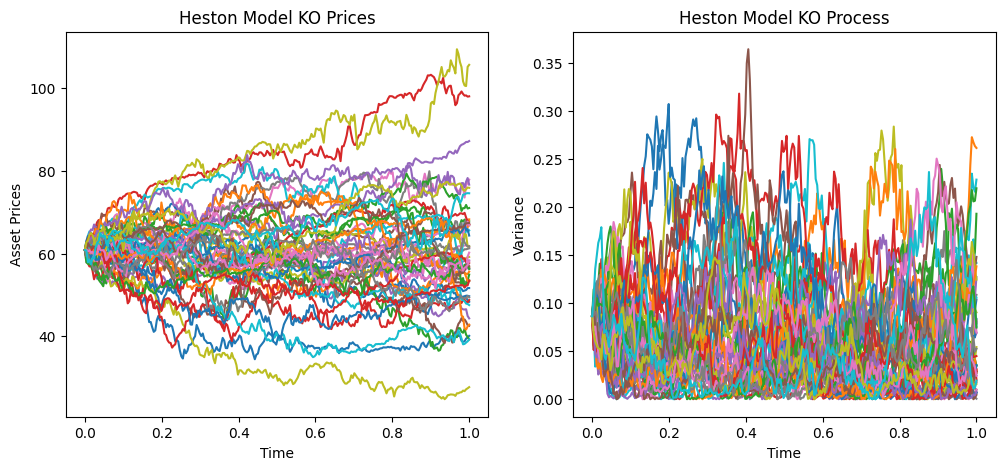

In [123]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
time = np.linspace(0,T,SIM_STEPS)
ax1.plot(time,sim_result_s[:,0,:first_n_paths], linewidth=0.5)
ax1.set_title('Heston Model KO Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')

ax2.plot(time,sim_result_v[:,0,:first_n_paths], linewidth=0.5)
ax2.set_title('Heston Model KO Variances')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')

plt.show()

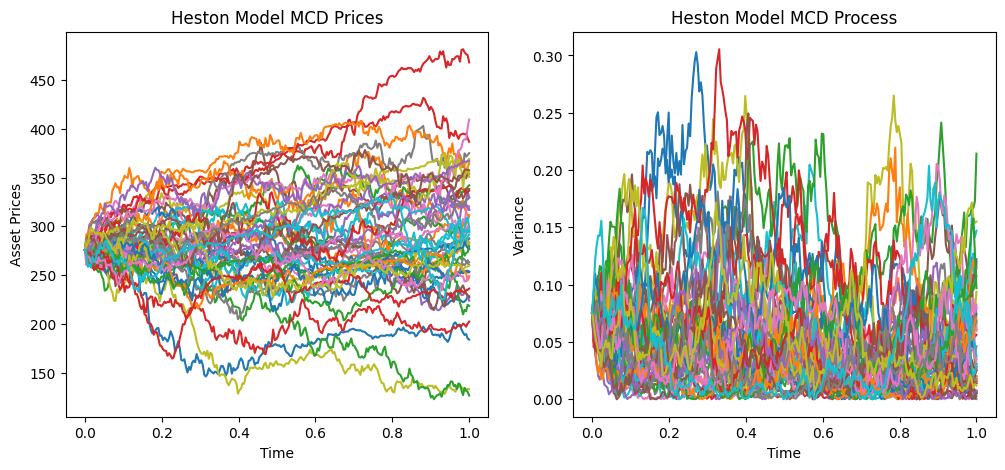

In [120]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
time = np.linspace(0,T,SIM_STEPS)
ax1.plot(time,sim_result_s[:,1,:first_n_paths])
ax1.set_title('Heston Model MCD Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')

ax2.plot(time,sim_result_v[:,1,:first_n_paths])
ax2.set_title('Heston Model MCD Process')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')

plt.show()

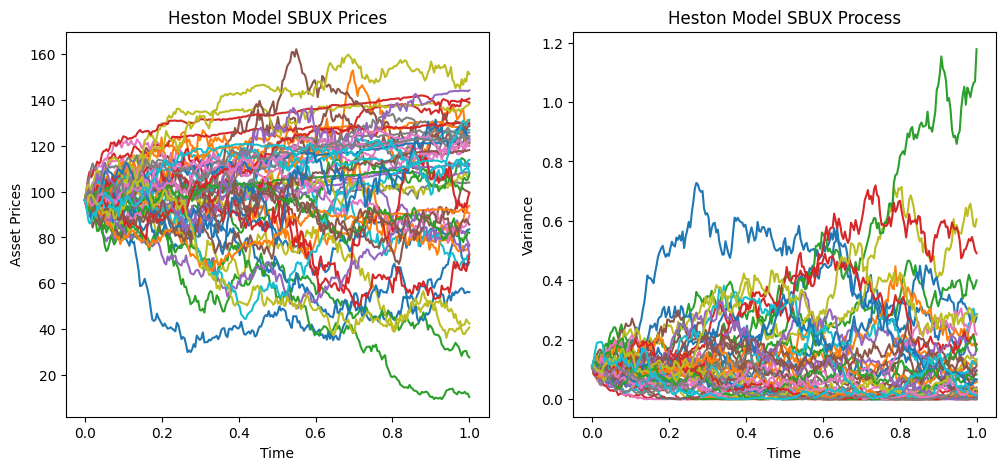

In [121]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
time = np.linspace(0,T,SIM_STEPS)
ax1.plot(time,sim_result_s[:,2,:first_n_paths])
ax1.set_title('Heston Model SBUX Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')

ax2.plot(time,sim_result_v[:,2,:first_n_paths])
ax2.set_title('Heston Model SBUX Process')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')

plt.show()

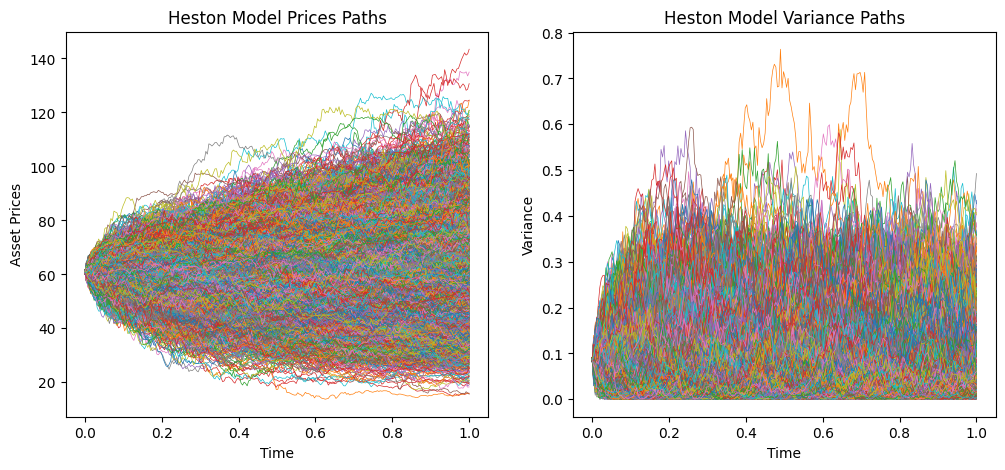

In [124]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
time = np.linspace(0,T,SIM_STEPS)
ax1.plot(time,sim_result_s[:,0,:], linewidth=0.5)
ax1.set_title('Heston Model Prices Paths')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')

ax2.plot(time,sim_result_v[:,0,:], linewidth=0.5)
ax2.set_title('Heston Model Variance Paths')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')

plt.show()

## Worst-of Barrier Put Option pricing

### 1. Parameter initialization

In [21]:
# Order: KO, MCD, SBUX
STRIKE = np.array([60.88, 275.88, 96.26])
BARRIER = STRIKE * 0.5
RATIO = np.array([16.4258, 3.6248, 10.3885])

In [22]:
# Given simulated paths of stock price

def masking(path, barrier): # path: sim_steps*num_stocks*sim_paths 3D array recording the simulated paths of stock price
    down_mask =np.full((path.shape[0],path.shape[1], path.shape[2]), np.nan)
    for i in range(path.shape[2]):
        down_mask[:,:,i] = path[:,:,i] <= barrier # at or below barrier according to term sheet
    return down_mask # a sim_steps*num_stocks*sim_paths 3D array recording the hit of each simulated price

def hit_or_not(mask):
    timepoints_hit = np.any(mask,axis = 1)
    path_hit = np.any(timepoints_hit,axis = 0)
    return path_hit # path_hit: a len=sim_paths 1D array recording the hit of each set of path of 3 stocks

def wstof_barrier_put_price(path, strike, barrier, ratio, rf, T):
    path_hit = hit_or_not(masking(path, barrier)) # 10000 1d array

    terminal_stock_price = path[-1,:,:] # 3*10000 2d array

    wst_stock = np.argmin(terminal_stock_price.T / strike, axis=1)

    S_T = np.full(terminal_stock_price.shape[1], np.nan)

    for i in range(terminal_stock_price.shape[1]):
        S_T[i] = terminal_stock_price[wst_stock[i],i]

    wst_stock = np.argmin(terminal_stock_price.T / strike, axis=1) # 10000 1d array
    wst_price = np.exp(-rf*T) * ratio[wst_stock] * np.maximum(strike[wst_stock] - S_T, 0)
    wst_barrier_price = np.mean(wst_price * path_hit)
    

    return wst_barrier_price


def wstof_barrier_put_future_price(path, strike, barrier, ratio, rf, T):
    path_part = path.copy()[:int(T*252),:,:]

    path_hit = hit_or_not(masking(path_part, barrier)) # 10000 1d array

    terminal_stock_price = path_part[-1,:,:] # 3*10000 2d array

    wst_stock = np.argmin(terminal_stock_price.T / strike, axis=1) # 10000 1d array

    S_T = np.full(terminal_stock_price.shape[1], np.nan)

    for i in range(terminal_stock_price.shape[1]):
        S_T[i] = terminal_stock_price[wst_stock[i],i]

    wst_future_price = ratio[wst_stock] * np.maximum(strike[wst_stock] - S_T, 0)
    wst_barrier_future_price = wst_future_price * path_hit
    

    return wst_barrier_future_price



In [30]:
option_price = wstof_barrier_put_price(sim_result_s, STRIKE, BARRIER, RATIO, RF_1Y, T)
option_price


67.90198625993261

In [70]:
rf_series = np.array([0.042, 0.046, 0.046, 0.046])
coupon_tenor = np.array([0.25,0.5,0.75,1])
disc = 1/((1 + rf_series)**coupon_tenor)
cf = 1000 * np.array([0.1025/4, 0.1025/4, 0.1025/4, 0.1025/4 + 1])
note_price = sum(cf*disc)
note_price

1055.714109436102

In [32]:
product_price = note_price - option_price
product_price

987.8121231761694

In [125]:
# Number of the occurrence of barrier event
sum(hit_or_not(masking(sim_result_s, BARRIER)))

1379

### 1. Dollar Delta

In [42]:
# Delta
def delta(wrt_s, shift_size = 0.01, S0 = sim_S0.copy(), v0 = sim_v0.copy(), kappa = kappa, theta = theta, sigma = sigma, rho = rho, lambd = lambd, T = T, rf = RF_1Y, cor_mat = corr_mat_ret.values, nstep = SIM_STEPS, npath = 10000):
    
    S0_shiftedup = None
    S0_shiftedup = S0.copy()
    S0_shifteddown = None
    S0_shifteddown = S0.copy()
    S0_shiftedup[wrt_s] = S0_shiftedup[wrt_s]*(1+shift_size)
    S0_shifteddown[wrt_s] = S0_shifteddown[wrt_s]*(1-shift_size)
    print(S0_shiftedup, S0_shifteddown)

    sim_result_s1, sim_result_v1 = heston_sim(S0_shiftedup, v0, kappa, theta, sigma, rho, lambd, T, rf, cor_mat, nstep, npath)
    option_price_delta1 = wstof_barrier_put_price(sim_result_s1, STRIKE, BARRIER, RATIO, rf, T)
    sim_result_s2, sim_result_v2 = heston_sim(S0_shifteddown, v0, kappa, theta, sigma, rho, lambd, T, rf, cor_mat, nstep, npath)
    option_price_delta2 = wstof_barrier_put_price(sim_result_s2, STRIKE, BARRIER, RATIO, rf, T)

    return -(option_price_delta1 - option_price_delta2) / (2*shift_size)


In [43]:
delta_KO = delta(0)
delta_MCD = delta(1)
delta_SBUX = delta(2)
print(delta_KO, delta_MCD, delta_SBUX)


[ 61.48880108 275.88000488  96.26000214] [ 60.27120106 275.88000488  96.26000214]
[ 60.88000107 278.63880493  96.26000214] [ 60.88000107 273.12120483  96.26000214]
[ 60.88000107 275.88000488  97.22260216] [ 60.88000107 275.88000488  95.29740211]
39.2954793023371 26.89928708904077 138.45559240569898


In [44]:
delta_all = pd.DataFrame({'KO': delta_KO, 'MCD': delta_MCD, 'SBUX': delta_SBUX}, index=[1])
delta_all.to_csv('Output/delta_Heston.csv')

### 2. Dollar Gamma

In [45]:
# Gamma
def gamma(wrt_s, shift_size = 0.01, S0 = sim_S0.copy(), v0 = sim_v0, kappa = kappa, theta = theta, sigma = sigma, rho = rho, lambd = lambd, T = T, rf = RF_1Y, cor_mat = corr_mat_ret.values, nstep = SIM_STEPS, npath = 10000):
    
    S0_pos_shifted = None
    S0_pos_shifted = sim_S0.copy()
    S0_pos_shifted[wrt_s] = S0_pos_shifted[wrt_s] * (1+shift_size)
    S0_neg_shifted = None
    S0_neg_shifted = sim_S0.copy()
    S0_neg_shifted[wrt_s] = S0_neg_shifted[wrt_s] * (1-shift_size)

    sim_result_s1, sim_result_v1 = heston_sim(S0_pos_shifted, v0, kappa, theta, sigma, rho, lambd, T, rf, cor_mat, nstep, npath)
    option_price_gamma1 = wstof_barrier_put_price(sim_result_s1, STRIKE, BARRIER, RATIO, rf, T)
    sim_result_s2, sim_result_v2 = heston_sim(S0_neg_shifted, v0, kappa, theta, sigma, rho, lambd, T, rf, cor_mat, nstep, npath)
    option_price_gamma2 = wstof_barrier_put_price(sim_result_s2, STRIKE, BARRIER, RATIO, rf, T)
    sim_result_s3, sim_result_v3 = heston_sim(S0, v0, kappa, theta, sigma, rho, lambd, T, rf, cor_mat, nstep, npath)
    option_price_gamma3 = wstof_barrier_put_price(sim_result_s3, STRIKE, BARRIER, RATIO, rf, T)


    return -(option_price_gamma1 - 2*option_price_gamma2 + option_price_gamma3) / (shift_size**2)

In [46]:
gamma_KO = gamma(0)
gamma_MCD = gamma(1)
gamma_SBUX = gamma(2)
print(gamma_KO, gamma_MCD, gamma_SBUX)

10013.28529021734 7318.111312548296 40902.97929340707


In [65]:
gamma_all = pd.DataFrame({'KO': gamma_KO, 'MCD': gamma_MCD, 'SBUX': gamma_SBUX}, index=[1])
gamma_all.to_csv('Output/gamma_Heston.csv')

### 3. Rho (PVBP)

In [47]:
# Rho (PVBP) 
def rho_greek(shift_size = 0.0001, S0 = sim_S0.copy(), v0 = sim_v0.copy(), kappa = kappa, theta = theta, sigma = sigma, rho = rho, lambd = lambd, T = T, rf = RF_1Y, cor_mat = corr_mat_ret.values, nstep = SIM_STEPS, npath = 10000):
    
    rf_shiftedup = rf
    rf_shiftedup = rf_shiftedup + shift_size
    rf_shifteddown = rf
    rf_shifteddown = rf_shifteddown - shift_size

    sim_result_s1, sim_result_v1 = heston_sim(S0, v0, kappa, theta, sigma, rho, lambd, T, rf_shiftedup, cor_mat, nstep, npath)
    option_price_rho1 = wstof_barrier_put_price(sim_result_s1, STRIKE, BARRIER, RATIO, rf_shiftedup, T)
    sim_result_s2, sim_result_v2 = heston_sim(S0, v0, kappa, theta, sigma, rho, lambd, T, rf_shifteddown, cor_mat, nstep, npath)
    option_price_rho2 = wstof_barrier_put_price(sim_result_s2, STRIKE, BARRIER, RATIO, rf_shifteddown, T)

    rf_series = np.array([0.042, 0.046, 0.046, 0.046])
    rf_series_shiftedup = rf_series.copy() + shift_size
    rf_series_shifteddown = rf_series.copy() - shift_size
    coupon_tenor = np.array([0.25,0.5,0.75,1])
    disc1 = 1/((1 + rf_series_shiftedup)**coupon_tenor)
    cf = 1000 * np.array([0.1025/4, 0.1025/4, 0.1025/4, 0.1025/4 + 1])
    note_price1 = sum(cf*disc1)
    disc2 = 1/((1 + rf_series_shifteddown)**coupon_tenor)
    note_price2 = sum(cf*disc2)

    return ((note_price1 - note_price2)-(option_price_rho1 - option_price_rho2))/2

In [48]:
rho_greek_all = rho_greek()
rho_greek_all

-0.12137754948601298

In [52]:
rho_all = pd.DataFrame({'Rho': rho_greek_all/2}, index=[1])
rho_all.to_csv('Output/rho_Heston.csv')

### 4. Vega

In [53]:
# Vega
def vega(wrt_s, shift_size = 0.01, S0 = sim_S0.copy(), v0 = sim_v0.copy(), kappa = kappa, theta = theta, sigma = sigma, rho = rho, lambd = lambd, T = T, rf = RF_1Y, cor_mat = corr_mat_ret.values.copy(), nstep = SIM_STEPS, npath = 10000):
    
    v0_shiftedup = None
    v0_shiftedup = v0.copy()
    v0_shiftedup[wrt_s] = (np.sqrt(v0_shiftedup[wrt_s]) + shift_size)**2
    v0_shifteddown = None
    v0_shifteddown = v0.copy()
    v0_shifteddown[wrt_s] = (np.sqrt(v0_shifteddown[wrt_s]) - shift_size)**2
    print(v0_shiftedup)

    sim_result_s1, sim_result_v1 = heston_sim(S0, v0_shiftedup, kappa, theta, sigma, rho, lambd, T, rf, cor_mat, nstep, npath)
    option_price_vega1 = wstof_barrier_put_price(sim_result_s1, STRIKE, BARRIER, RATIO, rf, T)
    sim_result_s2, sim_result_v2 = heston_sim(S0, v0_shifteddown, kappa, theta, sigma, rho, lambd, T, rf, cor_mat, nstep, npath)
    option_price_vega2 = wstof_barrier_put_price(sim_result_s2, STRIKE, BARRIER, RATIO, rf, T)

    return -(option_price_vega1 - option_price_vega2)/2

In [54]:
vega_KO = vega(0)
vega_MCD = vega(1)
vega_SBUX = vega(2)
print(vega_KO, vega_MCD, vega_SBUX)

[0.09234915 0.075212   0.11012843]
[0.08637135 0.08079696 0.11012843]
[0.08637135 0.075212   0.11686555]
-0.18140692781304324 -0.17504876230531607 -2.810077845522706


In [55]:
vega_all = pd.DataFrame({'KO': vega_KO, 'MCD': vega_MCD, 'SBUX': vega_SBUX}, index=[1])
vega_all.to_csv('Output/vega_Heston.csv')

### 5. Cega

In [61]:
# Cega
def cega(wrt_s1, wrt_s2, shift_size = 0.01, S0 = sim_S0.copy(), v0 = sim_v0.copy(), kappa = kappa, theta = theta, sigma = sigma, rho = rho, lambd = lambd, T = T, rf = RF_1Y, cor_mat = corr_mat_ret.values.copy(), nstep = SIM_STEPS, npath = 10000):
    
    cm_shiftedup = None
    cm_shiftedup = cor_mat.copy()
    cm_shiftedup[wrt_s1, wrt_s2] += shift_size
    cm_shiftedup[wrt_s2, wrt_s1] += shift_size
    cm_shifteddown = None
    cm_shifteddown = cor_mat.copy()
    cm_shifteddown[wrt_s1, wrt_s2] -= shift_size
    cm_shifteddown[wrt_s2, wrt_s1] -= shift_size
    print(cm_shiftedup, cm_shifteddown)

    sim_result_s1, sim_result_v1 = heston_sim(S0, v0, kappa, theta, sigma, rho, lambd, T, rf, cm_shiftedup, nstep, npath)
    option_price_cega1 = wstof_barrier_put_price(sim_result_s1, STRIKE, BARRIER, RATIO, rf, T)
    sim_result_s2, sim_result_v2 = heston_sim(S0, v0, kappa, theta, sigma, rho, lambd, T, rf, cm_shifteddown, nstep, npath)
    option_price_cega2 = wstof_barrier_put_price(sim_result_s2, STRIKE, BARRIER, RATIO, rf, T)

    return -(option_price_cega1 - option_price_cega2)/2

In [62]:
cega_KO = cega(0,1)
cega_MCD = cega(0,2)
cega_SBUX = cega(1,2)
print(cega_KO, cega_MCD, cega_SBUX)

[[1.         0.64657087 0.48842394]
 [0.64657087 1.         0.60835859]
 [0.48842394 0.60835859 1.        ]] [[1.         0.62657087 0.48842394]
 [0.62657087 1.         0.60835859]
 [0.48842394 0.60835859 1.        ]]
[[1.         0.63657087 0.49842394]
 [0.63657087 1.         0.60835859]
 [0.49842394 0.60835859 1.        ]] [[1.         0.63657087 0.47842394]
 [0.63657087 1.         0.60835859]
 [0.47842394 0.60835859 1.        ]]
[[1.         0.63657087 0.48842394]
 [0.63657087 1.         0.61835859]
 [0.48842394 0.61835859 1.        ]] [[1.         0.63657087 0.48842394]
 [0.63657087 1.         0.59835859]
 [0.48842394 0.59835859 1.        ]]
0.05493549307208667 0.05613118666559558 0.19707108910022697


In [63]:
cega_all = pd.DataFrame({'KO': cega_KO, 'MCD': cega_MCD, 'SBUX': cega_SBUX}, index=[1])
cega_all.to_csv('Output/cega_Heston.csv')

### 6. VaR

Simulation under P measure

In [20]:
def heston_sim_P(S0, v0, kappa, theta, sigma, rho, lambd, T, r, corr_mat_s,nstep, npath):
    # Based on Euler Discretisation of SDEs

    np.random.seed(4007)

    dt = T/nstep

    corr_mat_s_chol = np.linalg.cholesky(corr_mat_s)

    # Simulate Wiener's processes
    sim_result_s = np.full((nstep, len(S0), npath), fill_value=np.nan)
    sim_result_v = np.full((nstep, len(v0), npath), fill_value=np.nan)
    for path in range(npath):
        sim_result_s[:,:,path] = np.random.multivariate_normal(np.zeros(len(S0)), np.eye(len(S0)),size=(nstep))
        sim_result_s[:,:,path] = sim_result_s[:,:,path].dot(corr_mat_s_chol.T)
        # # One Wiener's process for each variance process
        # sim_result_v[:,:,path] = np.random.multivariate_normal(np.zeros(len(v0)), np.eye(len(v0)),size=(nstep))

        # One single Wiener's process for all variance processes, as justified by the 0.95+ correlation between historical variances of returns
        v_deltaW = np.random.normal(size=nstep)
        sim_result_v[:,:,path] = np.tile(v_deltaW, (len(v0), 1)).T

        sim_result_v[:,:,path] = sim_result_s[:,:,path] * rho + sim_result_v[:,:,path] * np.sqrt(1-rho**2)
        
    # Simulate stock prices and volatility
    for path in range(npath):
        for step in range(nstep):
            if step == 0:
                sim_result_s[step,:,path] = S0
                sim_result_v[step,:,path] = v0
            else:
                sim_result_s[step,:,path] = sim_result_s[step-1,:,path] * np.exp( (r - 0.5*sim_result_v[step-1,:,path])*dt + np.sqrt(sim_result_v[step-1,:,path] * dt) * sim_result_s[step,:,path] )
                sim_result_v[step,:,path] = np.maximum(sim_result_v[step-1,:,path] + kappa*(theta-sim_result_v[step-1,:,path])*dt + sigma*np.sqrt(sim_result_v[step-1,:,path]*dt)*sim_result_v[step,:,path],0)
    
    return sim_result_s, sim_result_v

In [27]:
mean_ret = log_returns.mean(axis=0)*252
sim_P_result_s, sim_P_result_v = heston_sim_P(sim_S0, sim_v0, kappa, theta, sigma, rho, lambd, T, mean_ret, corr_mat_ret.values, SIM_STEPS, 10000)

1 Year VaR

In [34]:
rf_series = np.array([0.046, 0.046, 0.046, 0.046])
coupon_tenor = np.array([0.25,0.5,0.75,1])
comp = (1 + rf_series)**(1 - coupon_tenor)
cf = 1000 * np.array([0.1025/4, 0.1025/4, 0.1025/4, 0.1025/4 + 1])
note_future_price = sum(cf*comp)

sim_future_pnl = note_future_price-wstof_barrier_put_future_price(sim_P_result_s, STRIKE, BARRIER, RATIO, RF_1Y, T)-1000
value_at_risk_95 = -np.percentile(sim_future_pnl, 0.05)
value_at_risk_975 = -np.percentile(sim_future_pnl, 0.025)
value_at_risk_99 = -np.percentile(sim_future_pnl, 0.01)
value_at_risk_999 = -np.percentile(sim_future_pnl, 0.001)

print(value_at_risk_95)
print(value_at_risk_975)
print(value_at_risk_99)
print(value_at_risk_999)

790.5809980251087
821.4180280881168
842.0764796928917
856.9395430748497


In [107]:
np.std(sim_future_pnl)

168.6599696903544

In [29]:
temp = pd.DataFrame(sim_future_pnl)
temp.to_csv('Output/Simulated_product_future_pnl.csv')


In [19]:
sim_future_pnl = pd.read_csv('Output/Simulated_product_future_pnl.csv')
value_at_risk_95 = -np.percentile(sim_future_pnl, 0.05)
value_at_risk_975 = -np.percentile(sim_future_pnl, 0.025)
value_at_risk_99 = -np.percentile(sim_future_pnl, 0.01)
print(value_at_risk_95)
print(value_at_risk_975)
print(value_at_risk_99)

756.1293486660375
830.377960735695


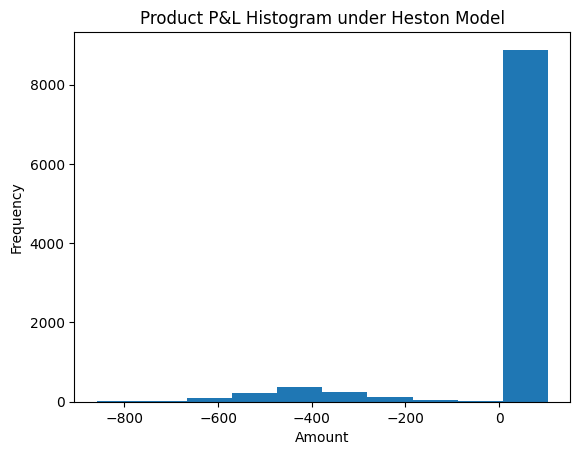

In [40]:
plt.hist(sim_future_pnl) # "sim_future_price" is indeed P&L
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Product P&L Histogram under Heston Model')

plt.show()

In [39]:
# Proportion of positive PnL
sum(sim_future_pnl >= 0) / len(sim_future_pnl)

0.8882

### 7. Expected Shortfall

1 Year ES

In [31]:
es_95 = -np.mean(sim_future_pnl[sim_future_pnl < -value_at_risk_95])
es_975 = -np.mean(sim_future_pnl[sim_future_pnl < -value_at_risk_975])
es_99 = -np.mean(sim_future_pnl[sim_future_pnl < -value_at_risk_99])

print(es_95)
print(es_975)
print(es_99)

828.6611978803161
843.6808711899859
858.5909945617339


# Black-Scholes Model

## Simulation

In [65]:
bs_S0 = stock_price.iloc[-1].values
bs_vol = np.sqrt(v0) # Annualized volatility

def bs_sim(S0, vol, T, r, corr_mat_s, nstep, npath):

    np.random.seed(4007)

    dt = T/nstep

    corr_mat_s_chol = np.linalg.cholesky(corr_mat_s)

    # Simulate Wiener's processes
    sim_result_s = np.full((nstep, len(S0), npath), fill_value=np.nan)
    for path in range(npath):
        sim_result_s[:,:,path] = np.random.multivariate_normal(np.zeros(len(S0)), np.eye(len(S0)),size=(nstep))
        sim_result_s[:,:,path] = sim_result_s[:,:,path].dot(corr_mat_s_chol.T)
        
    # Simulate stock prices and volatility
    for path in range(npath):
        for step in range(nstep):
            if step == 0:
                sim_result_s[step,:,path] = S0
            else:
                sim_result_s[step,:,path] = sim_result_s[step-1,:,path] * np.exp( (r - 0.5*vol**2)*dt + vol * np.sqrt(dt) * sim_result_s[step,:,path] )
    
    return sim_result_s



In [76]:
bs_sim_result = bs_sim(bs_S0, bs_vol, T, RF_1Y, corr_mat_ret.values, SIM_STEPS, 10000)

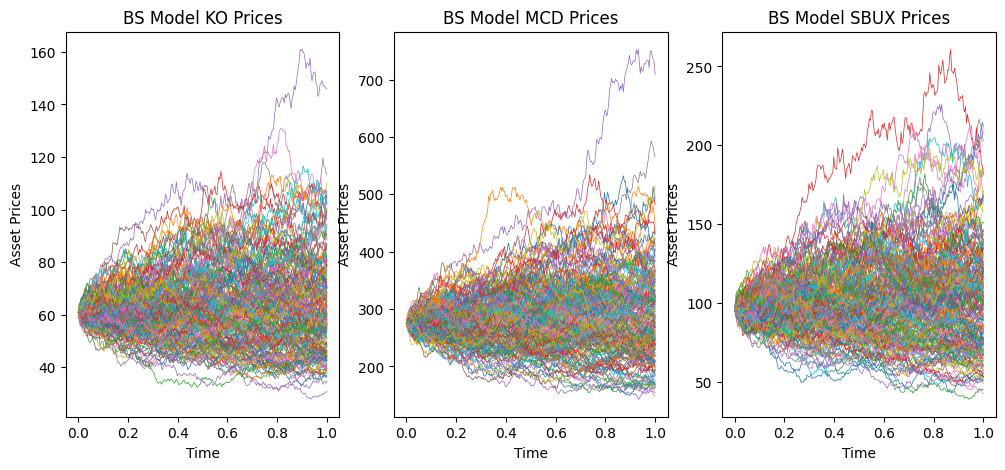

In [105]:
first_n_paths = 200

fig, (ax1,ax2,ax3)  = plt.subplots(1, 3, figsize=(12,5))
time = np.linspace(0,T,SIM_STEPS)
ax1.plot(time,bs_sim_result[:,0,:first_n_paths], linewidth=0.5)
ax1.set_title('BS Model KO Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')

ax2.plot(time,bs_sim_result[:,1,:first_n_paths], linewidth=0.5)
ax2.set_title('BS Model MCD Prices')
ax2.set_xlabel('Time')
ax2.set_ylabel('Asset Prices')

ax3.plot(time,bs_sim_result[:,2,:first_n_paths], linewidth=0.5)
ax3.set_title('BS Model SBUX Prices')
ax3.set_xlabel('Time')
ax3.set_ylabel('Asset Prices')

plt.show()

## Compute product price

In [77]:
option_price_bs = wstof_barrier_put_price(bs_sim_result, STRIKE, BARRIER, RATIO, RF_1Y, T)
option_price_bs

25.60828647660316

In [78]:
product_price_bs = note_price - option_price_bs
product_price_bs

1030.105822959499

In [80]:
# Number of the occurrence of barrier event
sum(hit_or_not(masking(bs_sim_result, BARRIER)))

531

## Risk Measures

In [88]:
# Simulate stock prices under P measure
mean_ret = log_returns.mean(axis=0)*252
bs_sim_result_P = bs_sim(bs_S0, bs_vol, T, mean_ret, corr_mat_ret.values, SIM_STEPS, 10000)



In [89]:
rf_series = np.array([0.046, 0.046, 0.046, 0.046])
coupon_tenor = np.array([0.25,0.5,0.75,1])
comp = (1 + rf_series)**(1 - coupon_tenor)
cf = 1000 * np.array([0.1025/4, 0.1025/4, 0.1025/4, 0.1025/4 + 1])
note_future_price = sum(cf*comp)

bs_sim_future_pnl = note_future_price-wstof_barrier_put_future_price(bs_sim_result_P, STRIKE, BARRIER, RATIO, RF_1Y, T)-1000
bs_value_at_risk_95 = -np.percentile(bs_sim_future_pnl, 0.05)
bs_value_at_risk_975 = -np.percentile(bs_sim_future_pnl, 0.025)
bs_value_at_risk_99 = -np.percentile(bs_sim_future_pnl, 0.01)
bs_value_at_risk_999 = -np.percentile(bs_sim_future_pnl, 0.001)

print(bs_value_at_risk_95)
print(bs_value_at_risk_975)
print(bs_value_at_risk_99)
print(bs_value_at_risk_999)

612.4864725354184
618.8693155615622
631.2156782230804
642.5964109304817


In [108]:
np.std(bs_sim_future_pnl)

117.8401603201455

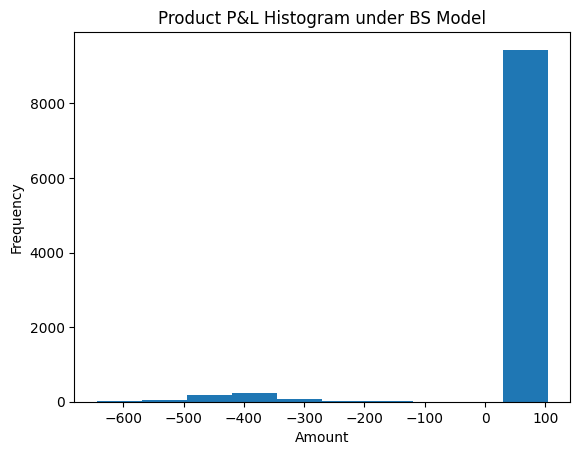

In [90]:
plt.hist(bs_sim_future_pnl) # "sim_future_price" is indeed P&L
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Product P&L Histogram under BS Model')

plt.show()

In [91]:
bs_es_95 = -np.mean(bs_sim_future_pnl[bs_sim_future_pnl < -bs_value_at_risk_95])
bs_es_975 = -np.mean(bs_sim_future_pnl[bs_sim_future_pnl < -bs_value_at_risk_975])
bs_es_99 = -np.mean(bs_sim_future_pnl[bs_sim_future_pnl < -bs_value_at_risk_99])

print(bs_es_95)
print(bs_es_975)
print(bs_es_99)

625.2225190003509
633.1276019413963
643.8609367868597


## Greeks

### Delta

In [92]:
# Delta
def bs_delta(wrt_s, shift_size = 0.01, S0 = bs_S0, vol = bs_vol, T = T, rf = RF_1Y, cor_mat = corr_mat_ret.values, nstep = SIM_STEPS, npath = 10000):
    
    S0_shiftedup = None
    S0_shiftedup = S0.copy()
    S0_shifteddown = None
    S0_shifteddown = S0.copy()
    S0_shiftedup[wrt_s] = S0_shiftedup[wrt_s]*(1+shift_size)
    S0_shifteddown[wrt_s] = S0_shifteddown[wrt_s]*(1-shift_size)
    print(S0_shiftedup, S0_shifteddown)

    sim_result_s1 = bs_sim(S0_shiftedup, vol, T, rf, cor_mat, nstep, npath)
    option_price_delta1 = wstof_barrier_put_price(sim_result_s1, STRIKE, BARRIER, RATIO, rf, T)
    sim_result_s2 = bs_sim(S0_shifteddown, vol, T, rf, cor_mat, nstep, npath)
    option_price_delta2 = wstof_barrier_put_price(sim_result_s2, STRIKE, BARRIER, RATIO, rf, T)

    return -(option_price_delta1 - option_price_delta2) / (2*shift_size)


In [ ]:
bs_delta_KO = bs_delta(0)
bs_delta_MCD = bs_delta(1)
bs_delta_SBUX = bs_delta(2)
print(bs_delta_KO, bs_delta_MCD, bs_delta_SBUX)

### Gamma

In [94]:
# Gamma
def bs_gamma(wrt_s, shift_size = 0.01, S0 = bs_S0, vol = bs_vol, T = T, rf = RF_1Y, cor_mat = corr_mat_ret.values, nstep = SIM_STEPS, npath = 10000):
    
    S0_pos_shifted = None
    S0_pos_shifted = S0.copy()
    S0_pos_shifted[wrt_s] = S0_pos_shifted[wrt_s] * (1+shift_size)
    S0_neg_shifted = None
    S0_neg_shifted = S0.copy()
    S0_neg_shifted[wrt_s] = S0_neg_shifted[wrt_s] * (1-shift_size)

    sim_result_s1 = bs_sim(S0_pos_shifted, vol, T, rf, cor_mat, nstep, npath)
    option_price_gamma1 = wstof_barrier_put_price(sim_result_s1, STRIKE, BARRIER, RATIO, rf, T)
    sim_result_s2 = bs_sim(S0_neg_shifted, vol, T, rf, cor_mat, nstep, npath)
    option_price_gamma2 = wstof_barrier_put_price(sim_result_s2, STRIKE, BARRIER, RATIO, rf, T)
    sim_result_s3 = bs_sim(S0, vol, T, rf, cor_mat, nstep, npath)
    option_price_gamma3 = wstof_barrier_put_price(sim_result_s3, STRIKE, BARRIER, RATIO, rf, T)


    return (option_price_gamma1 - 2*option_price_gamma2 + option_price_gamma3) / (shift_size**2)

In [102]:
bs_gamma_KO = bs_gamma(0, npath = 100000)
bs_gamma_MCD = bs_gamma(1, npath = 100000)
bs_gamma_SBUX = bs_gamma(2, npath = 100000)
print(bs_gamma_KO, bs_gamma_MCD, bs_gamma_SBUX)

17323.49742533472 9592.444642130999 37863.88998196731


### Rho

In [96]:
# Rho (PVBP) 
def bs_rho_greek(shift_size = 0.0001, S0 = bs_S0, vol = bs_vol, T = T, rf = RF_1Y, cor_mat = corr_mat_ret.values, nstep = SIM_STEPS, npath = 10000):
    
    rf_shiftedup = rf
    rf_shiftedup = rf_shiftedup + shift_size
    rf_shifteddown = rf
    rf_shifteddown = rf_shifteddown - shift_size

    sim_result_s1 = bs_sim(S0, vol, T, rf_shiftedup, cor_mat, nstep, npath)
    option_price_rho1 = wstof_barrier_put_price(sim_result_s1, STRIKE, BARRIER, RATIO, rf_shiftedup, T)
    sim_result_s2 = bs_sim(S0, vol, T, rf_shifteddown, cor_mat, nstep, npath)
    option_price_rho2 = wstof_barrier_put_price(sim_result_s2, STRIKE, BARRIER, RATIO, rf_shifteddown, T)

    rf_series = np.array([0.042, 0.046, 0.046, 0.046])
    rf_series_shiftedup = rf_series.copy() + shift_size
    rf_series_shifteddown = rf_series.copy() - shift_size
    coupon_tenor = np.array([0.25,0.5,0.75,1])
    disc1 = 1/((1 + rf_series_shiftedup)**coupon_tenor)
    cf = 1000 * np.array([0.1025/4, 0.1025/4, 0.1025/4, 0.1025/4 + 1])
    note_price1 = sum(cf*disc1)
    disc2 = 1/((1 + rf_series_shifteddown)**coupon_tenor)
    note_price2 = sum(cf*disc2)

    return ((note_price1 - note_price2)-(option_price_rho1 - option_price_rho2))/2

In [97]:
bs_rho_greek_all = bs_rho_greek()
bs_rho_greek_all

-0.07512397334560461

### Vega

In [98]:
# Vega
def bs_vega(wrt_s, shift_size = 0.01, S0 = bs_S0, vol = bs_vol, T = T, rf = RF_1Y, cor_mat = corr_mat_ret.values.copy(), nstep = SIM_STEPS, npath = 10000):
    
    v0_shiftedup = None
    v0_shiftedup = vol.copy()
    v0_shiftedup[wrt_s] = (np.sqrt(v0_shiftedup[wrt_s]) + shift_size)**2
    v0_shifteddown = None
    v0_shifteddown =vol.copy()
    v0_shifteddown[wrt_s] = (np.sqrt(v0_shifteddown[wrt_s]) - shift_size)**2
    print(v0_shiftedup)

    sim_result_s1 = bs_sim(S0, v0_shiftedup, T, rf, cor_mat, nstep, npath)
    option_price_vega1 = wstof_barrier_put_price(sim_result_s1, STRIKE, BARRIER, RATIO, rf, T)
    sim_result_s2 = bs_sim(S0, v0_shifteddown, T, rf, cor_mat, nstep, npath)
    option_price_vega2 = wstof_barrier_put_price(sim_result_s2, STRIKE, BARRIER, RATIO, rf, T)

    return -(option_price_vega1 - option_price_vega2)/2

In [99]:
bs_vega_KO = bs_vega(0)
bs_vega_MCD = bs_vega(1)
bs_vega_SBUX = bs_vega(2)
print(bs_vega_KO, bs_vega_MCD, bs_vega_SBUX)

[0.30483235 0.27424806 0.33185604]
[0.29389003 0.2848218  0.33185604]
[0.29389003 0.27424806 0.34347742]
-1.7026860024567885 -0.8648826477728058 -3.433496168533498


### Cega

In [100]:
# Cega
def bs_cega(wrt_s1, wrt_s2, shift_size = 0.01, S0 = bs_S0, vol = bs_vol, T = T, rf = RF_1Y, cor_mat = corr_mat_ret.values.copy(), nstep = SIM_STEPS, npath = 10000):
    
    cm_shiftedup = None
    cm_shiftedup = cor_mat.copy()
    cm_shiftedup[wrt_s1, wrt_s2] += shift_size
    cm_shiftedup[wrt_s2, wrt_s1] += shift_size
    cm_shifteddown = None
    cm_shifteddown = cor_mat.copy()
    cm_shifteddown[wrt_s1, wrt_s2] -= shift_size
    cm_shifteddown[wrt_s2, wrt_s1] -= shift_size
    print(cm_shiftedup, cm_shifteddown)

    sim_result_s1 = bs_sim(S0, vol, T, rf, cm_shiftedup, nstep, npath)
    option_price_cega1 = wstof_barrier_put_price(sim_result_s1, STRIKE, BARRIER, RATIO, rf, T)
    sim_result_s2 = bs_sim(S0, vol, T, rf, cm_shifteddown, nstep, npath)
    option_price_cega2 = wstof_barrier_put_price(sim_result_s2, STRIKE, BARRIER, RATIO, rf, T)

    return -(option_price_cega1 - option_price_cega2)/2

In [101]:
bs_cega_KO = bs_cega(0,1)
bs_cega_MCD = bs_cega(0,2)
bs_cega_SBUX = bs_cega(1,2)
print(bs_cega_KO, bs_cega_MCD, bs_cega_SBUX)

[[1.         0.64657087 0.48842394]
 [0.64657087 1.         0.60835859]
 [0.48842394 0.60835859 1.        ]] [[1.         0.62657087 0.48842394]
 [0.62657087 1.         0.60835859]
 [0.48842394 0.60835859 1.        ]]
[[1.         0.63657087 0.49842394]
 [0.63657087 1.         0.60835859]
 [0.49842394 0.60835859 1.        ]] [[1.         0.63657087 0.47842394]
 [0.63657087 1.         0.60835859]
 [0.47842394 0.60835859 1.        ]]
[[1.         0.63657087 0.48842394]
 [0.63657087 1.         0.61835859]
 [0.48842394 0.61835859 1.        ]] [[1.         0.63657087 0.48842394]
 [0.63657087 1.         0.59835859]
 [0.48842394 0.59835859 1.        ]]
0.06795320432626895 0.11601159514406234 0.021567054868096847
